In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_4983.json to spark_nlp_for_healthcare_spark_ocr_4983.json


In [ ]:
# Installing PySpark
!pip install -q pyspark==3.1.2 spark-nlp==3.4.2

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     |████████████████████████████████| 212.4 MB 56 kB/s 
     |████████████████████████████████| 142 kB 53.0 MB/s 
     |████████████████████████████████| 198 kB 43.3 MB/s 
     |████████████████████████████████| 188 kB 2.8 MB/s 
     |████████████████████████████████| 95 kB 2.2 MB/s 
     |████████████████████████████████| 66 kB 4.3 MB/s 


In [ ]:
from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

import sparknlp_jsl
import sparknlp

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)
# spark = sparknlp.start(spark32=True)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 3.4.2
Spark NLP_JSL Version : 3.5.0


In [ ]:
trainDataset = spark.read.parquet("/content/drive/MyDrive/JSL/DataMining_PubMed/train_part_80.parquet").coalesce(120)
testDataset = spark.read.parquet("/content/drive/MyDrive/JSL/DataMining_PubMed/test_part_20.parquet").coalesce(10)

In [ ]:
print(trainDataset.cache().count())
print(testDataset.cache().count())

160201
40050


In [ ]:
trainDataset.show(3)

+--------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|    PMID|               Title|       Journal|            Abstract|PublicationYear|  MeSHDescriptorName|   MeSHQualifierName|     class_20_labels|     class_10_labels|__index_level_0__|
+--------+--------------------+--------------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+-----------------+
|12135884|Bone morphogeneti...| Biol. Reprod.|Growth differenti...|           2002|[Amino Acid Seque...|[null, null, null...|[Humans, Molecula...|[Humans, Molecula...|            35298|
|21430226|Mice with disrupt...|   J. Immunol.|Type I protein ki...|           2011|[A Kinase Anchor ...|[immunology, null...|[Humans, Male, Tr...|[Mice, Humans, An...|           136306|
| 9582369|Overexpression of...|J. Biol. Chem.|Several recently ...|   

In [ ]:
## Remove empty list of labels from the train dataset
import pyspark.sql.functions as sf
trainDataset2 = trainDataset.filter(sf.size('class_10_labels') > 0)
# print(trainDataset2.cache().count())

In [ ]:
# trainDataset3 = trainDataset2.limit(50000)
trainDataset3 = trainDataset2.limit(5000)
print(trainDataset3.cache().count())

5000


In [ ]:
testDataset2 = testDataset.limit(500)
print(testDataset2.cache().count())

500


In [ ]:
from pyspark.ml import Pipeline

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *

### GloVe 100d embeddings

In [ ]:
document_assembler = DocumentAssembler() \
    .setInputCol("Title") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
      
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [ ]:
glove_embeddings = WordEmbeddingsModel().pretrained() \
      .setInputCols(["document",'lemma'])\
      .setOutputCol("embeddings")\
      .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")

multiClassifier = MultiClassifierDLApproach()\
        .setInputCols(["sentence_embeddings"])\
        .setOutputCol("class")\
        .setLabelColumn("class_10_labels")\
        .setBatchSize(64)\
        .setMaxEpochs(10)\
        .setLr(1e-3)\
        .setThreshold(0.5)\
        .setShufflePerEpoch(False)\
        .setEnableOutputLogs(True)\
        .setValidationSplit(0.1)

# classsifierdl = ClassifierDLApproach()\
#       .setInputCols(["sentence_embeddings"])\
#       .setOutputCol("class")\
#       .setLabelColumn("class_10_labels")\
#       .setMaxEpochs(3)\
#       .setEnableOutputLogs(True)
#       .setOutputLogsPath('logs')

clf_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            glove_embeddings,
            embeddingsSentence,
            multiClassifier])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
# Train (3 min for 3 epochs)
%%time

clf_pipelineModel = clf_pipeline.fit(trainDataset3)

CPU times: user 736 ms, sys: 88.7 ms, total: 825 ms
Wall time: 1min 25s


In [ ]:
!ls -l ~/annotator_logs/

total 4
-rw-r--r-- 1 root root 1645 Apr 25 04:09 MultiClassifierDLApproach_ca99fe4171cc.log


In [ ]:
!cat ~/annotator_logs/MultiClassifierDLApproach_58d2769863c0.log

cat: /root/annotator_logs/MultiClassifierDLApproach_58d2769863c0.log: No such file or directory


In [ ]:
preds = clf_pipelineModel.transform(testDataset2)

In [ ]:
preds.select('class_10_labels','Title',"class.result").show(10)

+--------------------+--------------------+--------------------+
|     class_10_labels|               Title|              result|
+--------------------+--------------------+--------------------+
|[Transcription Fa...|Separation of sho...|[Molecular Sequen...|
|[Transcription Fa...|Apontic binds the...|[Humans, RNA, Mes...|
|     [Mice, Animals]|Inhibition of in ...|   [Humans, Animals]|
|[Transcription Fa...|The Drosophila ki...|[Molecular Sequen...|
|           [Animals]|FGF8 induces form...|   [Humans, Animals]|
|[Mice, Molecular ...|Mrj encodes a Dna...|[Humans, Animals,...|
|[Transcription Fa...|Clinical and func...|   [Humans, Animals]|
|[Humans, Molecula...|Upregulation of h...|[Humans, Base Seq...|
|[Transcription Fa...|The role of RBF i...|           [Animals]|
|            [Humans]|Substrate specifi...|[Humans, Molecula...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [ ]:
preds_df = preds.select('class_10_labels', 'class.result').toPandas()

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

mlb = MultiLabelBinarizer()


y_true = mlb.fit_transform(preds_df['class_10_labels'])
y_pred = mlb.fit_transform(preds_df['result'])


print("Classification report: \n", (classification_report(y_true, y_pred)))
print("F1 micro averaging:",(f1_score(y_true, y_pred, average='micro')))
print("ROC: ",(roc_auc_score(y_true, y_pred, average="micro")))

Classification report: 
               precision    recall  f1-score   support

           0       0.71      0.85      0.77       299
           1       0.65      0.31      0.42       134
           2       0.58      0.04      0.07       195
           3       0.67      0.72      0.69       242
           4       0.53      0.40      0.46       157
           5       0.66      0.44      0.52       154
           6       0.75      0.44      0.56       122
           7       0.53      0.09      0.15       104
           8       0.64      0.16      0.25       179
           9       0.60      0.21      0.31       102

   micro avg       0.66      0.42      0.52      1688
   macro avg       0.63      0.36      0.42      1688
weighted avg       0.64      0.42      0.46      1688
 samples avg       0.67      0.46      0.50      1688

F1 micro averaging: 0.5176895306859206
ROC:  0.6572788595828468


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [ ]:
cm_labels = ['Animals',
 'Humans',
 'Mice',
 'Transcription Factors',
 'Molecular Sequence Data',
 'DNA-Binding Proteins',
 'Promoter Regions, Genetic',
 'Base Sequence',
 'Transcription, Genetic',
 'RNA, Messenger']

In [ ]:
cm = mcm(y_true, y_pred)

In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

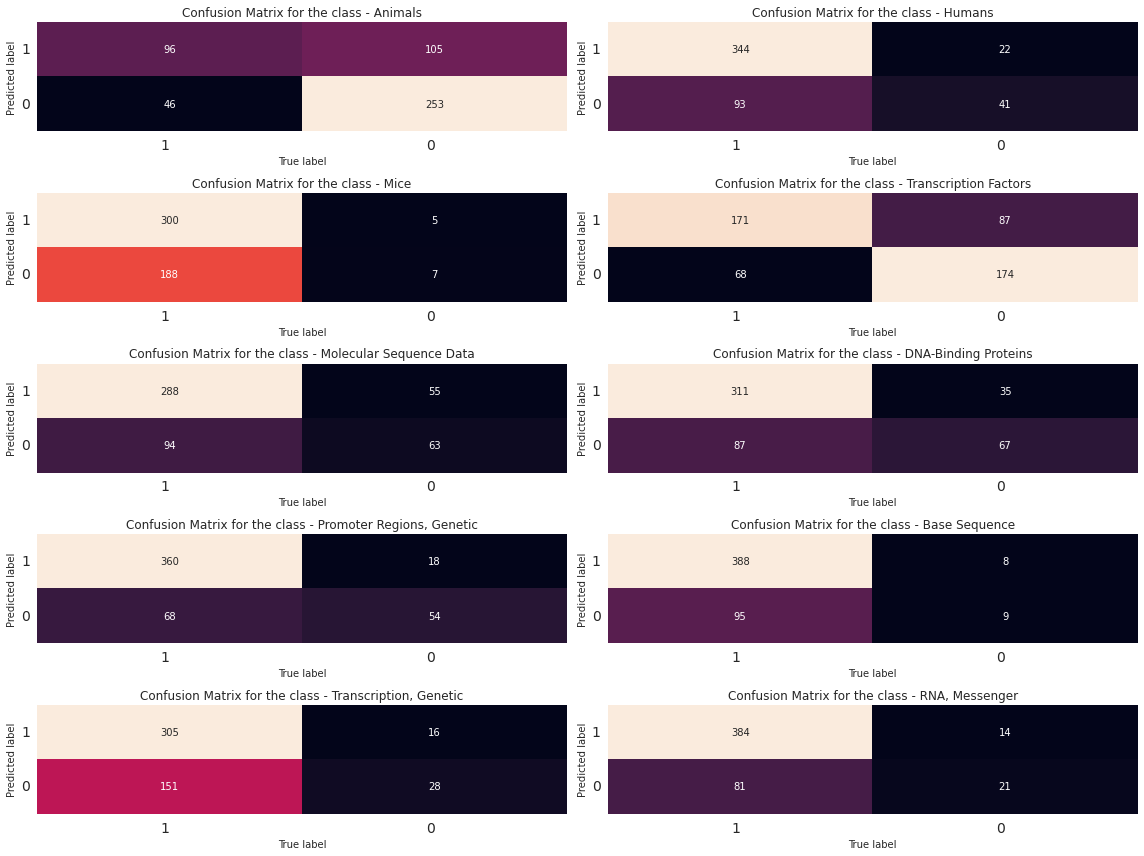

In [ ]:
#print_confusion_matrix(mcm(targets, val_preds),class_label=labels, class_names=labels)
sns.set_style("whitegrid")
fig, ax = plt.subplots(5, 2, figsize=(16, 12))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()